In [1]:
# This notebook is for creating random monotonic models of Uranus.
# The only constraints on the model are the that innermost shell has a temperature less than 50K
# and that the temperature/density/composition/pressure are monotonically decreasing as the radius increases.

In [2]:
import random
import numpy           as np
from matplotlib        import pyplot as plt
from matplotlib.pyplot import figure, legend

import lib.constants   as constants
import lib.profile     as profile
import lib.temperature as temperature
import lib.mc_interior as mc_interior

In [3]:
# Set for Uranus
mass = constants.URANUS.mass
moment_ratio = constants.URANUS.moment_ratio
radius = constants.URANUS.radius
num_shells = 100


In [4]:
INVERSE = True
USE_IRON = True

In [5]:
# Create a bunch of random models.
# Note:  Running this cell will take a while (each model takes ~3 seconds),
# So generating 1000 should take about an hour.

catalog = temperature.iron_sio2_water_eos_env_catalog() if USE_IRON else temperature.sio2_water_eos_env_catalog()
max_temp = 0 if INVERSE else 50000
smooth = 201

good_models = []
bad_models = []
for i in range(1):
    seed, vals, inner_temp, count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells,
                                                                 max_temp, catalog,smooth=smooth, inverse=INVERSE)
    if vals is not None:
        good_models.append((seed, vals, inner_temp, count))
    else:
        bad_models.append((seed, count))

In [6]:
# This cell is a list of the "valid models".
# The values you get are:
#
# idx, (seed, (mix), t, count)
#
# Where:
# idx     -- The number of the model
# seed    -- The seed of model.   Save this to recreate a model below.
# (mix)   -- The mix ratio of the model.   Note that these values are in order
#            of "composition", from lightest to heaviest.
# t       -- Temperature of inner shell
# count   -- The number of points during the model generation that were
#            set to Null.   We later "plaster ower" these points, but they
#            can potentially be points where the model is not monotonic
#            in one of its measures.

[x for x in enumerate(good_models)]

[(0, (468.715673954, [0.17, 0.54, 0.29, 0.0], 27965.6985171529, 0))]

In [7]:
# You can go into more depth on specific models by reusing the seed of the model.
# As long as the max_temp/catalog/etc. is the same, this should recreate the model.

def full_model(seed, catalog=catalog, smooth=201, max_temp=max_temp, inverse=False):
    s, m, t, c = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                              max_temp=max_temp, temperature_catalog=catalog, smooth=smooth,
                                              seed=seed, full_model=True, inverse=inverse)

    # Plot density
    #m.plot_densities()
    #figure()
    
    # Plot pressure
    #m.plot_pressure()
    #figure()
    
    # Plot temperature
    m.plot_temp(catalog._name)
    figure()
    
    # Plot composition
    m.plot_mix()
    figure()

    # plot temp profiles
    m_profile = profile.TemperatureProfile(catalog, m)
    #m_profile.plot_temperature_profile()
    print(m.get_mix_ratios())
    return m

# This code will try to run the algorithm from both sides and if they both succeed, combine em.
# Note, we need both ends to have zero bad points.   I think it's sufficient to have the regular method succeed.
# with count =0 for this to work.
def both_ends(seed, catalog=catalog, smooth=201, max_temp=max_temp, min_temp=0):
    try:
        s, m_f, t, c = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                  max_temp=max_temp, temperature_catalog=catalog, smooth=smooth,
                                                  seed=seed, full_model=True, inverse=False)
        s, m_i, t, c = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                                  max_temp=min_temp, temperature_catalog=catalog, smooth=smooth,
                                                  seed=seed, full_model=True, inverse=True)
    except:
        print("could not get both models to work for seed %s"%s)
    # Note this code is currently *only* built to work with the sio2/water/env and iron/sio2/water/env catalogs.
    # The plan is as follows:
    # Take all shells where both m_f and m_i have water (1>comp>-1), and take the one that has less water,
    # under the constraint that it's still monotonic.   In theory, m_i should always have a smaller composition
    # than m_f, which should make it easy --- just take m_f until the water amount in m_i is less, then use m_i to the end.
    cf = m_f.get_composition()
    ci = m_i.get_composition()

    cc = [x if abs(x) > abs(y) else y for (x,y) in zip(cf,ci)]
    mix = []
    for comp in cc:
        mix.append(catalog.composition_to_mix(comp))
        
    both =  mc_interior.MCInterior(m_f.get_radii(), m_f.get_densities(),mix, catalog)
    # Plot density
    both.plot_densities()
    figure()
    
    # Plot pressure
    both.plot_pressure()
    figure()
    
    # Plot temperature
    m_f.plot_temp("forward")
    m_i.plot_temp("inverse")
    figure()
    
    # Plot composition
    m_f.plot_mix()
    figure()
    
    m_i.plot_mix()
    figure()

    m_f.plot_composition("forward composition")
    m_i.plot_composition("inverse composition")
    #both.plot_composition("both composition")
    figure()
    # plot temp profiles
    m_profile = profile.TemperatureProfile(catalog, both)
    m_profile.plot_temperature_profile()
    print("regualr  :", m_f.get_mix_ratios())
    print("inverse  :", m_i.get_mix_ratios())
    print("both ends:", both.get_mix_ratios())

    
    

[0.15, 0.66, 0.19, 0.0]
[0.27, 0.73, 0.0]
[0.35, 0.65]


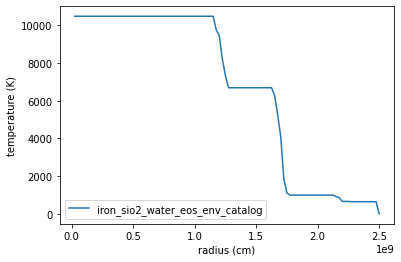

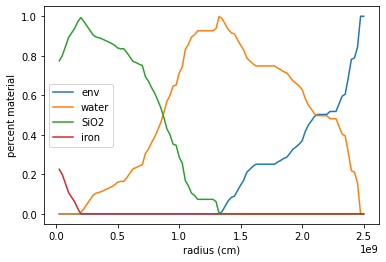

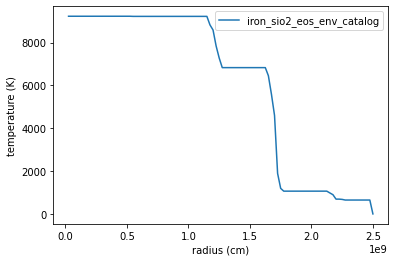

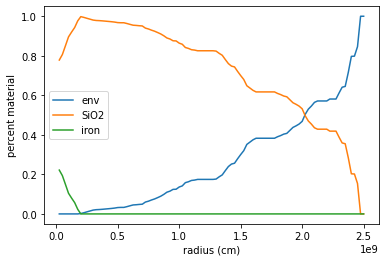

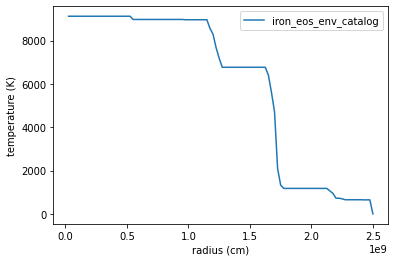

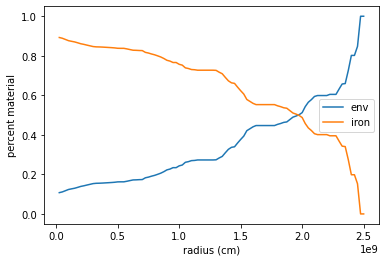

<Figure size 432x288 with 0 Axes>

In [8]:
m_seed = 0.137659367

aa =full_model(m_seed, catalog=temperature.iron_sio2_water_eos_env_catalog(), smooth=smooth, inverse=True, max_temp =0)
bb =full_model(m_seed, catalog=temperature.iron_sio2_eos_env_catalog(), smooth=smooth, inverse=True, max_temp =0)
cc =full_model(m_seed, catalog=temperature.iron_eos_env_catalog(), smooth=smooth, inverse=True, max_temp =0)

regualr  : [0.12, 0.7, 0.18, 0.0]
inverse  : [0.16, 0.68, 0.16, 0.0]
both ends: [0.15, 0.67, 0.18, 0.0]


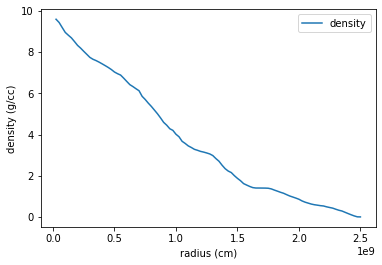

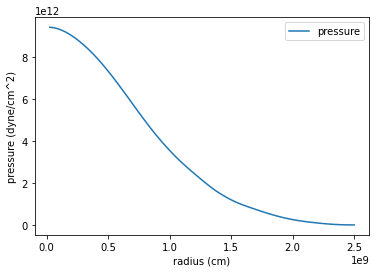

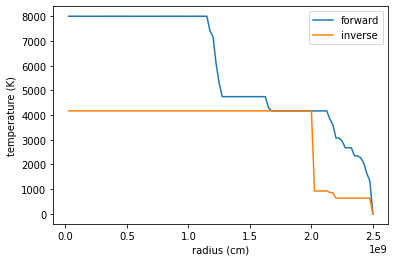

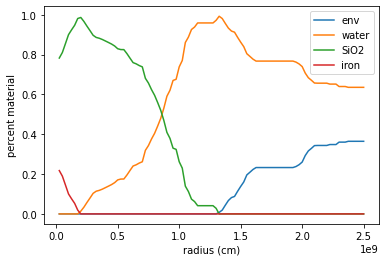

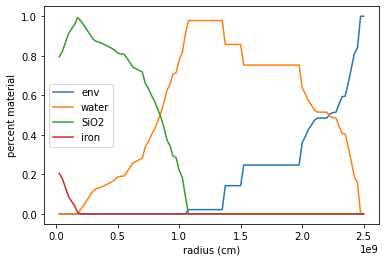

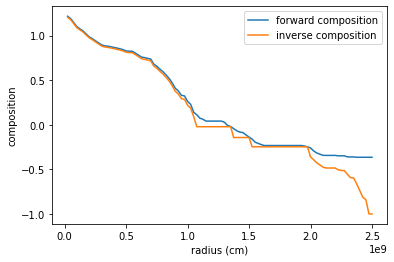

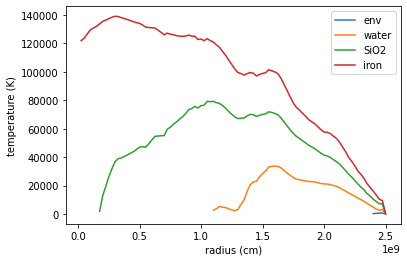

In [9]:
both_ends(0.137659367, catalog=temperature.iron_sio2_water_env_catalog(), max_temp=8000, smooth=smooth)

In [41]:
catalog.get_temp(0, 0.267, 1e6)

476.24899715252536

In [54]:
catalog2= temperature.iron_sio2_water_env_catalog()

print(catalog.get_composition(100.003, 0.2669, 6.2e9))
print(catalog2.get_composition(100.003, 0.2669, 6.2e9))

-0.6470341920011017
None
